# Subspaces, PCA and Nearest Neighbor

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge

Last Update 3/03/2022

**The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [27]:
import numpy as np
from matplotlib import pylab as plt
import math as math
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
%matplotlib inline


In this notebook we introduce a principled manner of selecting a smaller dimensional subspace fueled in part by the desire to carry out nearest neighbor calculations faster.  We will use the digits dataset to motivate and illustrate.

To begin here is the nearest neighbor implementation fromt the previous notebook

# Part 1: What is PCA

There are many ways to introduce Principal Components Analysis.  Here we will choose a rather visual and hopefully intuitive way of seeing what it means for a dimension to be a principal component.

In particular, the first principal component has a ready explanation. It is the direction along which the sample variance of the data is largest.  To expand this sentence, consider all possible single dimension in a higher dimensional space. For all such dimensions the data may be projected onto that dimension and then the sample variance calculated.  Unless there are ties - equally good directions to choose from - then there will exist one unique direction that is better - higher variance - than all others. 

That is call the first principal component.  Let see this for highly controlled data - samples from a 2D Gaussian Random Variable - in a way that we can literally see the first principal component.

(-14.0, 13.0)

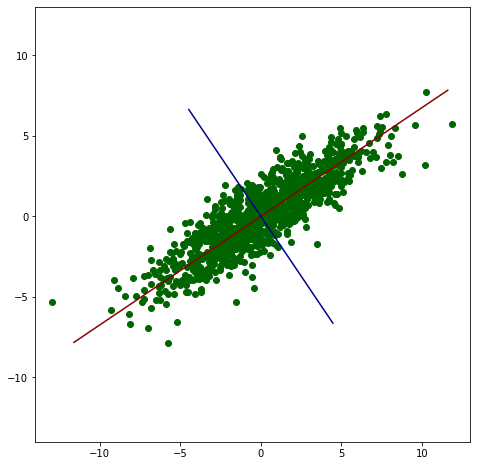

In [28]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=[[0.0,0.0]], 
           cluster_std=[[4.0,1.0]], shuffle=True, random_state=None)

theta = np.radians(35)
Rot = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

Xr = np.matmul(X,Rot.T)

pca = PCA(2)
pca.fit(Xr)
Xrcps = pca.components_

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.scatter(Xr[:,0], Xr[:,1],color='darkgreen')
pc1rg = [-14,14]
pc2rg = [-8,8]
ax.plot([(Xrcps[0]*i)[0] for i in pc1rg],[(Xrcps[0]*i)[1] for i in pc1rg],color='darkred')
ax.plot([(Xrcps[1]*i)[0] for i in pc2rg],[(Xrcps[1]*i)[1] for i in pc2rg],color='darkblue')
rmin = math.floor(X.min())
rmax = math.ceil(X.max())
ax.set_xlim(rmin,rmax)
ax.set_ylim(rmin,rmax)

# And now a 3D Example

In [29]:
X, y = make_blobs(n_samples=1000, n_features=3, centers=[[0.0,0.0,0.0]], 
           cluster_std=[[9.0,4.0,1.0]], shuffle=True, random_state=None)

### 3D Plotting with Plotly Express



Below we are working with a graphics API called [plotly_express](https://plotly.com/python/plotly-express/).  Likely you will need to install this and there are two ways to do this. First, if you run the command below it will most likely set you up for the duration of this session. It will not carry over to new sessions (tomorrow).

Another way is to permenantly add it to your system, so for example, if you are using Conda the this will probably work (worked for me):

`conda install -c plotly plotly_express `

In [30]:
# pip install plotly_express

import plotly.express as px

## 3D Illustration of First Principal Component

The following example first creates an axis-aligned Gaussian with most of the variance on the zero'th axis.

Then the point cloud is rotated into a new space.

The PCA is used to recover the direction of the original axis of maximum sample variance as expressed in the new space.

In [31]:
nsam = 256

X, y = make_blobs(n_samples=nsam, n_features=3, centers=[[0.0,0.0,0.0]], 
           cluster_std=[[9.0,4.0,2.0]], shuffle=True, random_state=42)

In [32]:
trace1 = go.Scatter3d(
   x = X[:,0], y = X[:,1], z = X[:,2], mode = 'markers', showlegend=False,
    marker = dict(
      size = 4
      )    
   )
bnd = 30
axes = [go.Scatter3d(x = [-bnd,bnd], y = [0,0], z = [0,0], mode = 'lines', showlegend=False),
        go.Scatter3d(x = [0,0], y = [-bnd,bnd], z = [0,0], mode = 'lines', showlegend=False),
        go.Scatter3d(x = [0,0], y = [0,0], z = [-bnd,bnd], mode = 'lines', showlegend=False)]

layout = go.Layout(title = 'Gaussian Sample: Sigmas are 9.0, 4.0 and 2.0',
                  colorway=["black", "red", "green", "blue"], width=800, height=800,)

fig = go.Figure(data = [trace1] + axes, layout = layout)

fig.show()

## Generate a Random Rotation

Now let us rotate the data so it is expressed in a new randomly chosen set of three mutually orthongal basis vectors.

In [33]:
seed = 12
rng = np.random.default_rng(seed)

row1 = 2 * rng.random(3) - 1
row1 = row1 / np.linalg.norm(row1)
up   = 2 * rng.random(3) - 1
row2 = np.cross(up,row1)
row2 = row2 / np.linalg.norm(row2)
row3 = np.cross(row1,row2)
Rot = np.array([row1, row2, row3])
print(f'Test Rot times Rot transpose is identify:\n {np.matmul(Rot.T,Rot)}')

Test Rot times Rot transpose is identify:
 [[ 1.00000000e+00  3.28414675e-17 -1.08097145e-16]
 [ 3.28414675e-17  1.00000000e+00  1.17794973e-16]
 [-1.08097145e-16  1.17794973e-16  1.00000000e+00]]


In [34]:
Xr = np.matmul(X,Rot.T)

In [35]:
trace1 = go.Scatter3d(
   x = Xr[:,0], y = Xr[:,1], z = Xr[:,2], mode = 'markers', showlegend=False,
    marker = dict(
      size = 4
      )    
   )
bnd = 30
axes = [go.Scatter3d(x = [-bnd,bnd], y = [0,0], z = [0,0], mode = 'lines', showlegend=False),
        go.Scatter3d(x = [0,0], y = [-bnd,bnd], z = [0,0], mode = 'lines', showlegend=False),
        go.Scatter3d(x = [0,0], y = [0,0], z = [-bnd,bnd], mode = 'lines', showlegend=False)]

layout = go.Layout(title = 'Gaussian Sample Randomly Rotated',
                  colorway=["black", "red", "green", "blue"], width=800, height=800,)

fig = go.Figure(data = [trace1] + axes, layout = layout)

fig.show()

# Apply PCA to rotated data

Now let us apply Principal Component Analysis to our 3D Gaussian data, a.k.a Point Cloud

In [36]:
pca = PCA(3)
pca.fit(Xr)

Xcps = pca.components_

angle = np.degrees(np.arccos(Xcps[0] @ Rot.T[0]))
print(f'Angle in degrees between R first row and first principal component: {angle:6.2f}')

Angle in degrees between R first row and first principal component:   1.47


In [37]:
pca = PCA(3)
pca.fit(Xr)

Xcps = pca.components_

trace1 = go.Scatter3d(
   x = Xr[:,0], y = Xr[:,1], z = Xr[:,2], mode = 'markers', showlegend=False,
    marker = dict(
      size = 4
      )    
   )
bnd = 30
axes = [go.Scatter3d(x = [-bnd,bnd], y = [0,0], z = [0,0], mode = 'lines', showlegend=False),
        go.Scatter3d(x = [0,0], y = [-bnd,bnd], z = [0,0], mode = 'lines', showlegend=False),
        go.Scatter3d(x = [0,0], y = [0,0], z = [-bnd,bnd], mode = 'lines', showlegend=False)]

pcStart = bnd*Xcps
pcEnd   = -bnd*Xcps
pctraces = [go.Scatter3d(x = [pcStart[0,0],pcEnd[0,0]], 
                         y = [pcStart[0,1],pcEnd[0,1]], 
                         z = [pcStart[0,2],pcEnd[0,2]], mode = 'lines', showlegend=False),
            go.Scatter3d(x = [pcStart[1,0],pcEnd[1,0]], 
                         y = [pcStart[1,1],pcEnd[1,1]], 
                         z = [pcStart[1,2],pcEnd[1,2]], mode = 'lines', showlegend=False),
            go.Scatter3d(x = [pcStart[2,0],pcEnd[2,0]], 
                         y = [pcStart[2,1],pcEnd[2,1]], 
                         z = [pcStart[2,2],pcEnd[2,2]], mode = 'lines', showlegend=False)
]

layout = go.Layout(title = 'Gaussian Sample Randomly Rotated',
                   colorway=["black", "grey", "grey", "grey", "red", "green", "blue"], 
                   width=800, height=800,)

fig = go.Figure(data = [trace1] + axes + pctraces, layout = layout)

fig.show()

## Come Full Circle

Because we know how the data was originally rotated we know the direction of the `true` first principal component. Now we can empirically observe the difference in angle between the estimated direction of maximum variance and the `true` direction.

In [38]:
angle = np.degrees(np.arccos(Xcps[0] @ Rot.T[0]))
print(f'Angle in degrees between R first row and first principal component: {angle:6.2f}')

Angle in degrees between R first row and first principal component:   1.47


# Part 2: PCA, NN and MNIST

We begin by reintroducing our nearest neighbor classifier from the previous lecture

Bring in the digits dataset - recall each image is a point in 64 dimensional space.

In [39]:
from sklearn import datasets
digits = datasets.load_digits()

X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


## PCA on MNIST

Now let us see through example what PCA does on $64$ dimensional data. 


Note the example below can be adjusted to seek a different number of principal components with a useful minimum of 2 and a pratical useful upper bound of 10.  This is adjusted using ```subspace_size```

In [61]:
from sklearn.decomposition import PCA

subspace_size = 8
# subspace_size = 16
pca = PCA(n_components=subspace_size)
pca.fit(X)

PCA(n_components=8)

In the next cell observe that a single command projects the original images (points in 64 dimensions) down to a subspace of size defined above. Note here that the entire dataset is being projected down into a lower dimensional subspace.  When doing PCA to reduce dimensionality in practice often the training data only is used to define the subspace.

In [62]:
Xs = pca.transform(X)
Xs.shape

(1797, 8)

## Plotting in 2D the first 2 Components

What follows will generate a scatter plot of the 10 digit classes as projected onto the first two principle components. If there are more than two dimensions the code does nothing but print a message

In [63]:
def plot_if_only_two_dim(X, y) :
    if X.shape[1] == 2 :
        my_colors = ['red', 'green', 'blue', 'darkred', 'darkgreen', 'darkblue','orange','purple','cyan','magenta']

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.scatter(Xs[:,0], Xs[:,1], c=[my_colors[i] for i in y])
        ax.set_xlabel('First PC')
        ax.set_ylabel('Second PC')
    else :
        print("Not plotting since more than two dimensions")
        
plot_if_only_two_dim(Xs, y)       

Not plotting since more than two dimensions


## Plotting in 3D with first 3 Components

If we select a subspace size of 3 here is what the data looks like

In [64]:
def plot_if_only_three_dim(X, y) :
    if X.shape[1] == 3 :
        mnist_labels = [f'Digit {i}' for i in y ]
        cols = {'PC 1' : X[:,0], 'PC 2' : X[:,1],'PC 3' : X[:,2], 'label' : mnist_labels}

        df = pd.DataFrame(data=cols)

        fig = px.scatter_3d(df, x='PC 1', y='PC 2', z='PC 3',
                   color='label', size_max=0.00001)
        fig.update_layout(dict1={"title" : {"text": "MNIST in PCA 3D Subspace"},
                         "width" : 800, "height" : 800})                    
        fig.show()
        
    else :
        print("Not plotting because subspace is not 3D")
    pass

plot_if_only_three_dim(Xs, y)

Not plotting because subspace is not 3D


# Nearest Neighbor in Subspace

Below are two different versions of a nearest neighbor classifier object.  The old one exactly matches the previous lecture. The new one is written to be more efficient by avoiding the unnecessary construction of intermediate lists. 

The return the same accuracy and so they are useful for measuring nearest neighbor accuracy as you place with subspaces of varying dimension from 2, 3, up to say 16.  There are two punchlines you should come away with:

* First, dropping the number of dimensions drops the overal accuracy by relatively little.  
* Once the more efficient class definition is used, the speedup associated with fewer dimensions is clearly evident.


In [65]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

class nearest_neighbor_old:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, q):
        distances = [distance(q, self.X[i]) 
                     for i in range(len(self.X))]
        return np.argmin(distances)
    def predict(self, q) :
        return self.y[self.get_nearest(q)]

In [66]:

class nearest_neighbor_new:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y
    def get_nearest(self, q):
        nn = np.argmin(np.linalg.norm(self.X - q,axis=1))
        return nn
    def predict(self, q) :
        return self.y[self.get_nearest(q)]

## Compare Ambient to Subspace Accuracy

Here is the actual comparison using 30 percent of the data as test and the rest as training.

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, y, test_size=0.30, shuffle=True, random_state=42)

use_new = True

if use_new :
    nnF = nearest_neighbor_new()
    nnS = nearest_neighbor_new()
else :
    nnF = nearest_neighbor_old()
    nnS = nearest_neighbor_old()  

nnF.fit(X_train, y_train)
nnS.fit(Xs_train, ys_train)

def predict_with_nnF() :
    y_pred = np.array([nnF.predict(X_test[i]) for i in range(len(X_test))])
    acc = np.sum(y_pred == y_test)/len(y_test)
    print(f'The nnF accuracy is {acc:.3f}')
    
def predict_with_nnS() :
    y_pred = np.array([nnS.predict(Xs_test[i]) for i in range(len(Xs_test))])
    acc = np.sum(y_pred == ys_test)/len(ys_test)
    print(f'The nnS accuracy is {acc:.3f}')    
    
%timeit -r 1 -n 1 predict_with_nnF()
%timeit -r 1 -n 1 predict_with_nnS()

The nnF accuracy is 0.983
72 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
The nnS accuracy is 0.963
25.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note that run time drops by more than a factor of 3 when using 8 dimensions versus the original 64.

# Part 3: Looking at Principal Components

The remainder of this notebook emphasizes that fact that a component - being a vector if length 64 - may be thought of as an image. Indeed, it may be displayed as an image and the pattern of the principle vectors as images reveals something about the structure of our data. 

In [68]:
Xcps = pca.components_
Xcps.shape

(8, 64)

In [69]:
foo = pca.explained_variance_ratio_
np.sum(foo)

0.6739030807611003

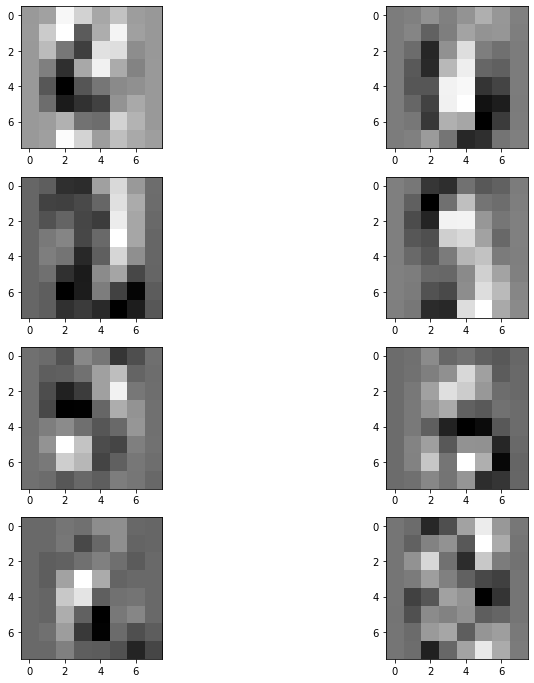

In [70]:
Xcps = pca.components_
ncp  = Xcps.shape[0]
cols = 2
rows = math.ceil(ncp / cols)
cols
fig, axes = plt.subplots(rows, cols) 
fig.set_figheight(12)
fig.set_figwidth(12)
i = 0
for axr in axes :
    for ax in axr :
        if (i < ncp) :
            ax.imshow(np.resize(Xcps[i],(8,8)), 
                  cmap=plt.cm.gray_r, interpolation='nearest')
            i = i + 1


# Part 4: PCA and Image Reconstruction

Now one more thing.  Turns out, not at all by accident, that if one takes a weighted sum of principal components it is possible to create new image. But, much more important, if the weights are the coordinate values of an image projected into the PCA subspace then the reconstruction is an approximation to the original.  

Let us see this process in action.

Reconstructing from PCA Image 0 using 3 Principal Componenet.

In words ... what are we doing:
	Start with mean image and then ...
	Add   -1.26 times PC 1 to reconstruction.
	Add   21.27 times PC 2 to reconstruction.
	Add   -9.46 times PC 3 to reconstruction.


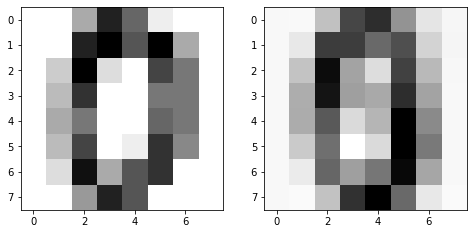

In [77]:
digits = datasets.load_digits()
subspace_size = 3
imindex = 0

print(f'Reconstructing from PCA Image {imindex} using {subspace_size} Principal Componenet.\n')

X = digits.data
y = digits.target
pca = PCA(n_components=subspace_size)
pca.fit(X)

Xs = pca.transform(X)
Xcps = pca.components_

if subspace_size < 9 :
    print('In words ... what are we doing:')
    print('\tStart with mean image and then ...')
    for i in range(subspace_size) :
        print(f'\tAdd {Xs[imindex,i]:7.2f} times PC {i+1} to reconstruction.')

recon = pca.mean_ + np.matmul(Xcps.T,Xs[imindex,:]) 

fig, axes = plt.subplots(1,2) 
fig.set_figheight(5)
fig.set_figwidth(8)
ax = axes[0]
ax.imshow(np.resize(X[imindex,:],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

ax = axes[1]
ax.imshow(np.resize(recon,(8,8)), cmap=plt.cm.gray_r, interpolation='nearest');